In [78]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict
pd.options.display.max_columns = 100
%matplotlib inline

# Member Info Model
This model will mostly use demographic characteristics of the member to predict voting behavior. Most data is from the Propublica member api endpoint.
## Feature Construction

In [47]:
df_members = pd.read_csv('../data/propublica/members_bio.csv', encoding = 'latin1')
columns = ['gender','last_name','member_id',
           'office','seniority', 'short_title', 
           'bills_cosponsored', 'bills_sponsored', 
           'congress', 'date_of_birth']
df_members = df_members.loc[df_members.congress >= 105, columns]
df_members['date_of_birth'] = pd.to_datetime(df_members.date_of_birth)
c1 = df_members.short_title == 'Rep.'
c2 = df_members.short_title == 'Sen.'
df_members = df_members[c1 | c2]
gb = ['congress', 'short_title']
df_avg = df_members.groupby(gb).agg(['mean', 'std']).drop('seniority', axis = 1).reset_index()
df_members = pd.merge(df_members, df_avg, how = 'left', on = gb)

# get sponsorship count zscore
df_members['cosponsored_z'] = (df_members.bills_cosponsored - df_members[('bills_cosponsored', 'mean')]) / df_members[('bills_cosponsored', 'std')]
df_members['sponsored_z']  = (df_members.bills_sponsored - df_members[('bills_sponsored', 'mean')]) / df_members[('bills_sponsored', 'std')]
df_members = df_members[[x for x in df_members.columns if type(x) == str]]
df_members.reset_index(drop=True, inplace = True)

# extract office info
office = df_members.office.str.split(" ", expand = True)
office.rename(columns={0: 'room',1:'building'}, inplace = True)
office = office[['room', 'building']]
df_members = pd.concat([df_members, office], axis = 1)

# get order in which they vote
# previous research has found this to be significant
df_members.sort_values(['congress','short_title', 'last_name'], inplace=True)
vote_order = []
last_v = 'Rep.'
order = 0
for i, row in df_members.iterrows():
    if row.short_title != last_v:
        order = 0
    last_v = row.short_title
    vote_order.append(order)
    order += 1
df_members['vote_order'] = vote_order

# get vote data
def get_full_set(path):
    for dataset in ['train','dev','test']:
        df = pd.read_csv(path + dataset + '.csv', encoding = 'latin1')
        if dataset == 'train':
            df_votes = df
        else:
            df_votes = pd.concat([df_votes, df])
    return df_votes
df_votes = get_full_set('../data/model/')
df_votes = pd.merge(df_votes, df_members, how = 'left', on = ['member_id', 'congress'])

# get age of member at vote time
df_vote_date = pd.read_csv('../data/propublica/votes_both.csv')
cols = ['chamber', 'congress', 'session', 'roll_call']
df_vote_date = df_vote_date[cols + ['date']]
df_vote_date.drop_duplicates(subset=cols, inplace = True)
df_votes = pd.merge(df_votes, df_vote_date, how = 'left', on = cols)
df_votes.dropna(subset=['date_of_birth'], inplace = True)
df_votes['date'] = pd.to_datetime(df_votes.date)
df_votes['age'] = ((df_votes.date - df_votes.date_of_birth).dt.days / 365).apply(lambda x: int(x))

# grab cosponsor list
df_bills = pd.read_csv('../data/propublica/billsfull_model.csv', encoding = 'latin1')
df_bills.dropna(subset=['sponsor_id'], inplace = True)
def fix_eval(row):
    """Combination of different API pulls from different people resulted in lists being inconsistenly stored
        Also append the sponsor id
    """
    try:
        new = eval(row.cosponsor)
        if type(new[0]) == list:
            new = new[0]
    except NameError:
        new = row.cosponsor.replace('[', "")
        new = new.replace(']', "")
        new = new.split(', ')
    except:
        if type(row.cosponsor) == float:
            new = []
        else:
            new = row.cosponsor
    new.append(row.sponsor_id)
    return new
df_bills['cosponsor_ids'] = df_bills.apply(fix_eval, axis = 1)
cols = ['sponsor_party', 'cosponsor_ids', 'rsponsor', 'dsponsor', 'bill_id']
df_bills = df_bills[cols].dropna(subset = ['bill_id'])
df_votes = pd.merge(df_votes, df_bills, how = 'left', on = 'bill_id')
def calc_party_alignment(row):
    """Get ratio of cosponsor party relative to member party"""
    r_count = row.rsponsor
    d_count = row.dsponsor
    if row.sponsor_party == 'R':
        r_count += 1
    elif row.sponsor_party == 'D':
        d_count += 1
    
    denom = d_count + r_count
    if denom == 0:
        return np.nan
    if row.party == 'R':
        return r_count / denom
    elif row.party == 'D':
        return d_count / denom
df_votes['spon_party_ratio'] = df_votes.apply(calc_party_alignment, axis = 1)

# Get a bunch of info on cosponsors
df_votes.dropna(subset=['cosponsor_ids'], inplace = True)
df_votes['cs_count'] = df_votes.cosponsor_ids.apply(lambda x: len(x))
member_info = defaultdict(lambda: defaultdict(dict))
for i, row in df_members.iterrows():
    info = row[['building', 'gender','seniority','room']].to_dict()
    member_info[row.member_id][row.congress] = info
df_votes.reset_index(inplace=True, drop=True)
cs_stats = []
for i, row in df_votes.iterrows():
    buildings = []
    genders = []
    rooms = []
    seniorities = []
    for cosponsor in row.cosponsor_ids:
        cs_info = member_info[cosponsor][row.congress]
        if cs_info:
            buildings.append(cs_info['building'])
            genders.append(cs_info['gender'])
            rooms.append(cs_info['room'])
            seniorities.append(cs_info['seniority'])
    male_percent = len([x for x in genders if x == 'M']) / row.cs_count
    sen_stats = pd.Series(seniorities).describe().to_dict()
    sen_stats = {'sen_' + a: b for a,b in sen_stats.items() if a not in ['std','count']}
    
    if row.building:
        same_building = np.mean([x==row.building for x in buildings])
        room_1 = str(row.room)
        same_floor = []
        for room in rooms:
            room = str(room)
            if len(room_1) != len(room):
                same_floor.append(False)
            if len(room_1) == 3:
                if room_1[0] == room[0]:
                    same_floor.append(True)
                else:
                    same_floor.append(False)
            if len(room_1) == 4:
                if room_1[:2] == room[:2]:
                    same_floor.append(True)
                else:
                    same_floor.append(False)
        same_floor = np.mean(same_floor)
    else:
        same_building = -1
        same_floor = -1
    stats = {'male_percent': male_percent, 
             'same_building': same_building, 
             'same_floor': same_floor}
    cs_stats.append({**stats, **sen_stats})
cs_stats = pd.DataFrame(cs_stats)
df_votes = pd.concat([df_votes, cs_stats], axis = 1)

# checkpoint export
df_votes.to_csv('../data/model/member_demo/features1.csv', index = False)
columns = cs_stats.columns.tolist()
columns += ['full_set_id', 'gender', 'seniority', 'short_title', 
            'cosponsored_z', 'sponsored_z', 'vote_order', 'age', 
            'spon_party_ratio', 'cs_count']
df_votes = df_votes[columns].dropna()
df_votes.to_csv('../data/model/member_demo/features2.csv', index = False)

C:\Users\Steve\Anaconda3\lib\site-packages\pandas\tools\merge.py:536: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\Steve\Anaconda3\lib\site-packages\pandas\tools\merge.py:862: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  self.right = self.right.drop(right_drop, axis=1)


## Modeling

In [194]:
test = pd.read_csv('../data/model/test.csv')
train = pd.read_csv('../data/model/train.csv')
dev = pd.read_csv('../data/model/dev.csv')
dfs = [train, dev, test]
def join_features(df):
    df = pd.merge(df, df_votes, on = 'full_set_id', how = 'left').dropna(subset = ['male_percent'])
    return df
model_train, model_dev, model_test =  map(join_features, dfs)

In [186]:
# baseline if randomly assign 1 at level proportional to overall rate
t = [1] * int(len(model_dev) * model_train.broke_from_party.mean())
t += ([0] *(len(model_dev) - len(t)))
t = shuffle(t)
print(metrics.classification_report(model_dev['broke_from_party'], t, digits=4))

             precision    recall  f1-score   support

          0     0.9464    0.9459    0.9461    465682
          1     0.0516    0.0521    0.0518     26317

avg / total     0.8985    0.8980    0.8983    491999



In [195]:
def bill_type(df):
    """Get bill type from bill id"""
    df['bill_type'] = df.bill_id.str.replace('[0-9]', '').str.replace("-", "")
    recode = {"hres": 'res', 'hconres': "conres", 'hjres': 'jres', 
              'sres': 'res', 'sconres':'conres', 'sjres': 'jres', 
              "s":'bill', 'hr': 'bill',
              "": "other", 'motion': "other", 'treatydoc':'other'}
    df['bill_type'] = df.bill_type.replace(recode)
    df = pd.concat([df, pd.get_dummies(df.bill_type, prefix='btype_')], 
                   axis = 1)
    return df
dfs = [model_train, model_dev, model_test]
model_train, model_dev, model_test =  map(bill_type, dfs)
def dummy_body(df):
    df = pd.concat([df, pd.get_dummies(df.short_title, prefix='title_')], 
                   axis = 1)
    df['is_male'] = df.gender == 'M'
    return df
dfs = [model_train, model_dev, model_test]
model_train, model_dev, model_test =  map(dummy_body, dfs)

In [196]:
features = [x for x in columns if x not in ['full_set_id', 'short_title', 'gender']]
features += [x for x in model_dev.columns if x.startswith('btype_')]
features += [x for x in model_dev.columns if x.startswith('title_')]
features += ['is_male']
rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=200)
rfc.fit(model_train[features], model_train['broke_from_party'])
model_dev[features].head(1)

,male_percent,same_building,same_floor,sen_25%,sen_50%,sen_75%,sen_max,sen_mean,sen_min,seniority,cosponsored_z,sponsored_z,vote_order,age,spon_party_ratio,cs_count,btype__bill,btype__conres,btype__jres,btype__res,title__Rep.,title__Sen.,is_male
0,1.0,-1.0,-1.0,27.0,34.0,41.0,48.0,34.0,20.0,6.0,0.249868,1.403126,44.0,53.0,1.0,2.0,1,0,0,0,1,0,True


C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


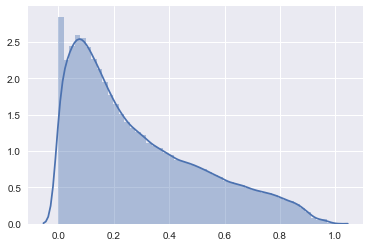

In [197]:
probs_dev = rfc.predict_proba(model_dev[features])[:,1]
probs_train = rfc.predict_proba(model_train[features])[:,1]
sns.distplot(probs_dev)

In [198]:
thresh = .75
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

26754
             precision    recall  f1-score   support

          0     0.9648    0.9639    0.9643    465682
          1     0.3715    0.3777    0.3746     26317

avg / total     0.9331    0.9325    0.9328    491999



In [200]:
def export_predictions(dfs, model, file_name, 
                       path = "../data/model/model_predictions/", 
                       predictors = features):
    """Exports probabilities for all sets
    Args:
        dfs: train, dev, test sets. in that order.
        model: sklearn model to get predictions
        path: where to export
        predictors: Column set to use as predictors
    """
    labels = ['train', 'dev', 'test']
    for label, df in zip(labels, dfs):
        probs = model.predict_proba(df[predictors])[:,1]
        probs = pd.DataFrame(probs, index = df.full_set_id, columns=['pred_probs'])
        probs.to_csv(path + file_name + "_" + label + ".csv")

with open('../data/model/member_demo/rfc_member_demos.pickle', 'wb') as f:
    pickle.dump(rfc, f)
dfs = [model_train, model_dev, model_test]
export_predictions(dfs, rfc, 'member_demos', predictors=features)